In [1]:
import pickle
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import numpy as np
import pandas as pd

In [31]:
result_dir = '/bsuscratch/zacharykeskinen/data/infrasound/wind_results'
fig_dir = '/bsuhome/zacharykeskinen/infrasound/figures'
tmp_dir = join(result_dir,'tmp')
super_x = []
for f in glob(join(tmp_dir, '*')):
    with open(f, 'rb') as f:
        df = pickle.load(f)
    super_x.append(df)
res = pd.concat(super_x)
res['wind_cat'] = pd.cut(res['wind'], bins = [0,2,5,10], labels = ['low-wind','med-wind','high-wind'])
with open(join(result_dir, 'windv2.pkl'), 'wb') as f:
    pickle.dump(res, f)


In [13]:
result_dir = '/bsuscratch/zacharykeskinen/data/infrasound/wind_results'
with open(join(result_dir, 'windv2.pkl'), 'rb') as f:
    wind = pickle.load(f)

In [4]:
wind[['fs','powers']] = pd.DataFrame(wind['power'].tolist(), index=wind.index)
wind = wind.loc[wind.cor < wind.cor.quantile(0.8)]
# wind = wind.loc[wind.wind > 6]
# wind = wind.drop(['power'], axis = 1)
powers = pd.DataFrame(wind['powers'].tolist(), index=wind.index, columns = wind.iloc[0]['fs'])
powers[['sd_delta','cor','wind']] = wind[['sd_delta','cor','wind']]
#powers.loc[powers.sd_delta < -0.5, 'sd_delta'] = -0.5
plot = powers.drop(['cor','wind'], axis= 1).groupby('sd_delta').mean()
new_index = np.linspace(plot.index[0], plot.index[-1], len(plot))
df_resampled = plot.reindex(plot.index.union(new_index)).interpolate(method='nearest').loc[new_index]

In [5]:
levels = [[None,0],[0,0.2],[0.2,0.4],[0.4,0.6],[0.6,0.8],[0.8,1],[1,1.2],[1.2,None]]
plot = pd.DataFrame()
for low, high in levels:
    d = {}
    if low == None:
        sub = powers.loc[powers.sd_delta < high]
        low = -0.2
    elif high == None:
        sub = powers.loc[powers.sd_delta > low]
    else:
        sub = powers.loc[(powers.sd_delta > low) & (powers.sd_delta < high)]
    sub = sub.drop(['sd_delta', 'cor', 'wind'], axis = 1).dropna().mean()
    sub.index = np.round(sub.index.astype(float),2)
    d[low] = sub
    plot = pd.concat([plot, pd.DataFrame.from_dict(d)], axis = 1)

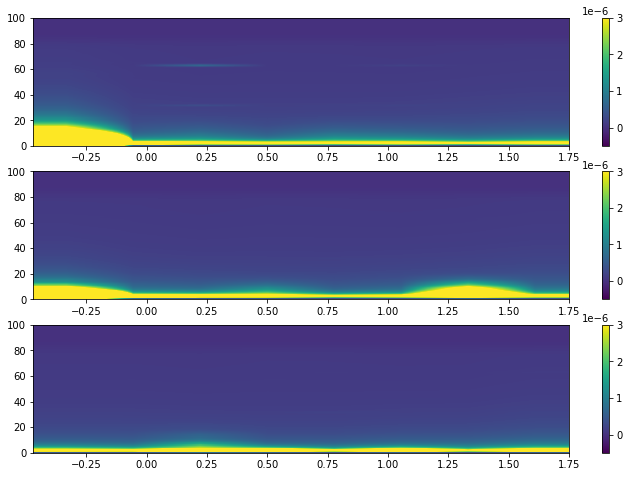

In [6]:
from re import A


f, axes = plt.subplots(3, figsize= (12,8))
levels = [[None,0],[0,0.2],[0.2,0.4],[0.4,0.6],[0.6,0.8],[0.8,1],[1,1.2],[1.2,None]]

for i, (low, high) in enumerate([[0,3],[3,5],[5,10]]):
    ax = axes[i]
    power_sub = powers.loc[(powers.wind < high) & (powers.wind > low)]
    plot = pd.DataFrame()
    for low, high in levels:
        d = {}
        if low == None:
            sub = power_sub.loc[power_sub.sd_delta < high]
            low = -0.2
        elif high == None:
            sub = power_sub.loc[power_sub.sd_delta > low]
        else:
            sub = power_sub.loc[(power_sub.sd_delta > low) & (power_sub.sd_delta < high)]
        sub = sub.drop(['sd_delta', 'cor', 'wind'], axis = 1).dropna().mean()
        sub.index = np.round(sub.index.astype(float),2)
        d[low] = sub
        plot = pd.concat([plot, pd.DataFrame.from_dict(d)], axis = 1)
    im = ax.imshow(plot[::-1], aspect = 'auto',vmin=-0.0000005, vmax=0.000003, interpolation = 'bilinear',extent = (df_resampled.index[0], df_resampled.index[-1], df_resampled.columns[0], df_resampled.columns[-1]))
    plt.colorbar(im, ax= ax)

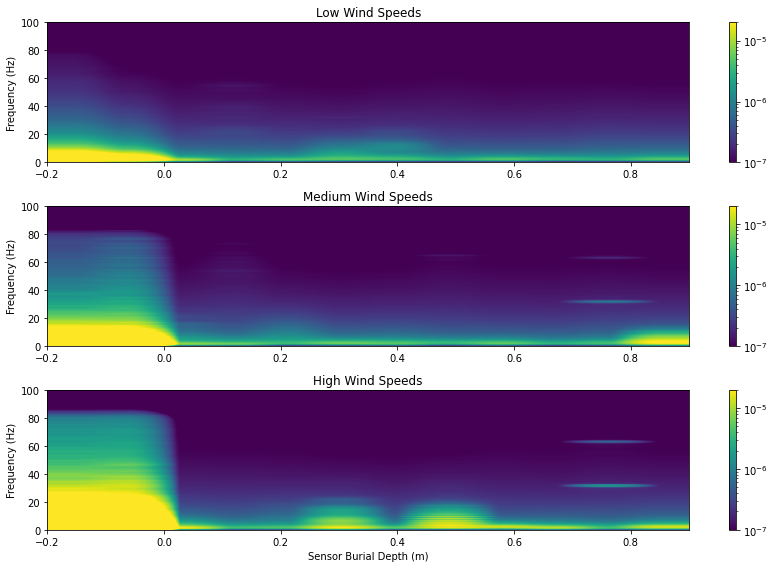

In [7]:
from matplotlib.colors import LogNorm
f, axes = plt.subplots(3, figsize= (12,8))
norm=LogNorm(vmin=1e-7, vmax=2e-5)
title_dic = {'0-3':'Low Wind Speeds', '3-5':'Medium Wind Speeds', '5-10':'High Wind Speeds'}
for i, (low, high) in enumerate([[0,3],[3,5],[5,10]]):
    ax = axes[i]
    with open(join(result_dir, 'windv2.pkl'), 'rb') as f:
        wind = pickle.load(f)
    wind[['fs','powers']] = pd.DataFrame(wind['power'].tolist(), index=wind.index)
    # wind = wind.loc[wind.cor < wind.cor.quantile(0.5)]
    wind.loc[wind.sd_delta < -0.2, 'sd_delta'] = -0.2
    powers = pd.DataFrame(wind['powers'].tolist(), index=wind.index, columns = wind.iloc[0]['fs'])
    powers[['sd_delta','cor','wind']] = wind[['sd_delta','cor','wind']]

    plot = powers.loc[(powers.wind < high) & (powers.wind > low)].drop(['cor','wind'], axis= 1).groupby('sd_delta').mean()
    new_index = np.linspace(plot.index[0], plot.index[-1], len(plot))
    #df_resampled = plot.reindex(plot.index.union(new_index)).interpolate(method='nearest').loc[new_index]
    df_resampled = plot.reindex(np.arange(-0.2, 1, 0.1), method = 'nearest')
    extent = (df_resampled.index[0], df_resampled.index[-1], df_resampled.columns[0], df_resampled.columns[-1])
    # extent = (-0.2,1,0,100)
    im = ax.imshow(df_resampled.T.iloc[::-1],extent = extent, aspect = 'auto', norm = norm, interpolation = None)
    ax.set_ylabel('Frequency (Hz)')
    title = title_dic[f'{low}-{high}']
    # ax.set_title(f'Wind Speeds from {low} to {high} m/s')
    ax.set_title(title)
    plt.colorbar(im, ax = ax)
axes[2].set_xlabel('Sensor Burial Depth (m)')
#plt.xlim(-0.2,0.5)
plt.tight_layout()

## scatter plots

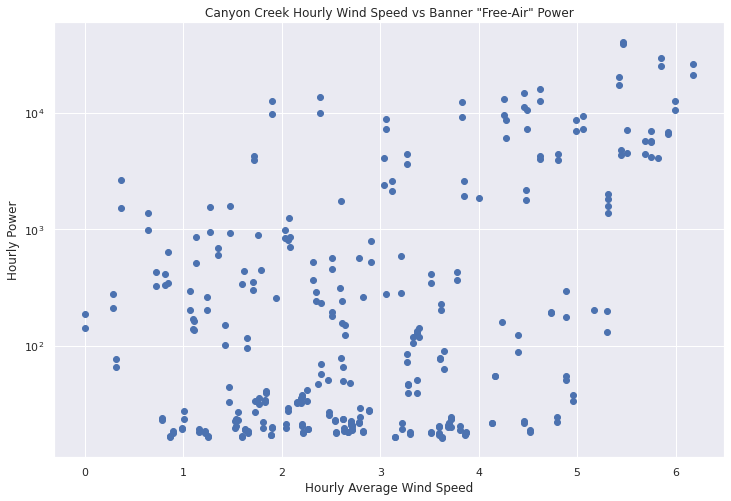

In [94]:
plt.subplots(figsize = (12,8))
plt.scatter(wind[(wind.sd_delta < -0.1) & (wind.cor > 0)].wind, wind[(wind.sd_delta < -0.1) & (wind.cor > 0)].broad_power)
plt.yscale('log')
plt.ylabel('Hourly Power')
plt.xlabel('Hourly Average Wind Speed')
plt.title('Canyon Creek Hourly Wind Speed vs Banner "Free-Air" Power')
plt.savefig(join(fig_dir, 'wind','free-air-canyon-scatter.png'))

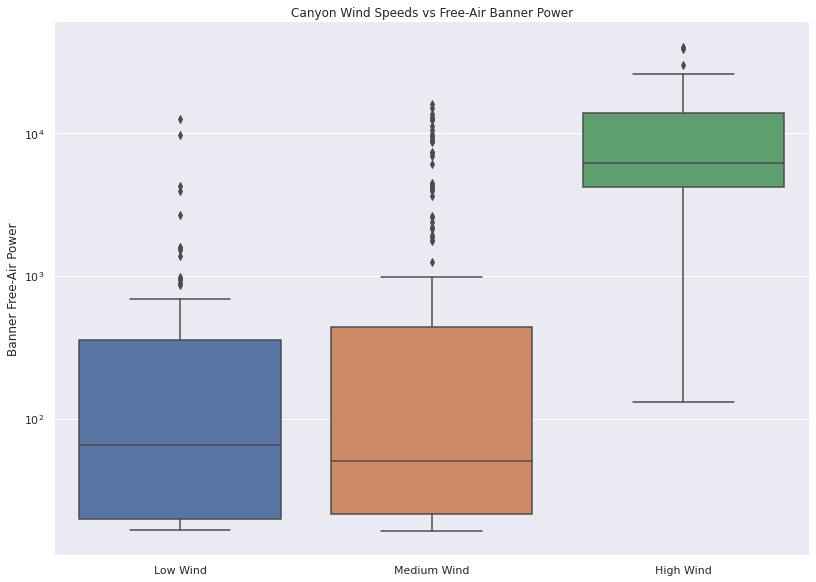

In [93]:

sns.catplot(data = wind[wind.sd_delta < -0.1], x = 'wind_cat', y = 'broad_power', kind = 'box', height=8.27, aspect=11.7/8.27)
plt.yscale('log')
plt.ylabel('Banner Free-Air Power')
plt.xlabel('')
plt.xticks(ticks = [0,1,2], labels = ['Low Wind','Medium Wind','High Wind'])
plt.title('Canyon Wind Speeds vs Free-Air Banner Power')
plt.savefig(join(fig_dir, 'wind','free-air-canyon-box.png'))

Text(0.5, 1.0, 'Hourly Power vs Burial Depth')

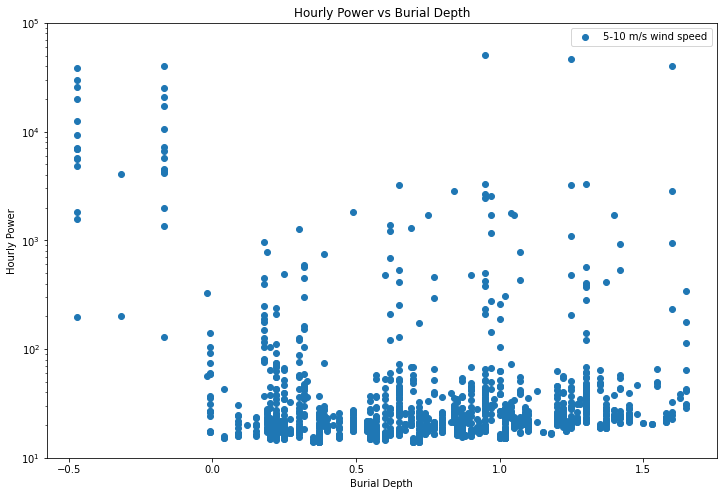

In [61]:
plt.subplots(figsize = (12,8))
for i, (low, high) in enumerate([[0,2],[2,5],[5,10]]):
    if i == 2:
        plot = wind.loc[(wind.wind < high) & (wind.wind > low)]
        plt.scatter(plot.sd_delta, plot.broad_power, label = f'{low}-{high} m/s wind speed')
plt.legend()
plt.yscale('log')
plt.ylim(10e0, 10e4)
plt.ylabel('Hourly Power')
plt.xlabel('Burial Depth')
plt.title('Hourly Power vs Burial Depth')

Text(0.5, 1.0, 'Hourly Power vs Burial Depth')

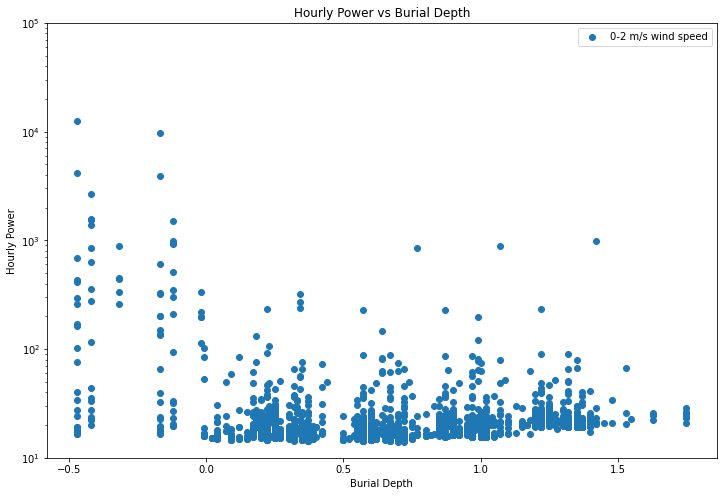

In [56]:
plt.subplots(figsize = (12,8))
for i, (low, high) in enumerate([[0,2],[2,5],[5,10]]):
    if i == 0:
        plot = wind.loc[(wind.wind < high) & (wind.wind > low)]
        plt.scatter(plot.sd_delta, plot.broad_power, label = f'{low}-{high} m/s wind speed')
plt.legend()
plt.ylim(10e0, 10e4)
plt.yscale('log')
plt.ylabel('Hourly Power')
plt.xlabel('Burial Depth')
plt.title('Hourly Power vs Burial Depth')